In [78]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

import numpy as np
from scipy.special import erfcinv
from scipy.stats import chi2, multivariate_normal, gamma
from scipy.special import erfinv, erf, erfc
from scipy.linalg import sqrtm, inv, eigh

import getdist
from getdist import plots, MCSamples
getdist.chains.print_load_details = False

import sys, os
import git

# Create the two toy chains and the joint chain:
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
path_global = os.path.dirname(path_git)
print('Path to git repo: {}'.format(path_global))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Path to git repo: /home/matias/Documents/PhD/code


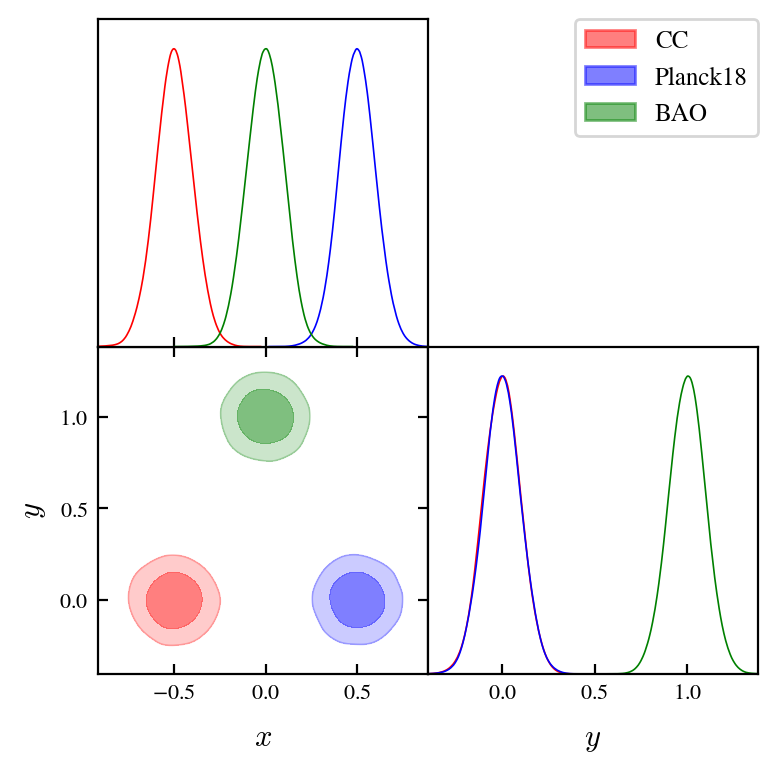

In [79]:
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, 1])

cov_A = 1*np.array([[0.01, 0.], [0., 0.01]])
cov_B = cov_A.copy()
cov_C = cov_A.copy()

# Plot the distribution of the center of mass

lim_x = np.array([-10, 10])
lim_y = np.array([-8, 1])


names = ['x', 'y']
labels = names
samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')

colors = ['red', 'blue', 'green', 'purple']

g = plots.get_subplot_plotter()
g.triangle_plot([chain_A, chain_B, chain_C],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors,
                legend_labels=['CC', 'Planck18', 'BAO'])
os.chdir(os.path.join(path_git, 'notebooks', 'figures'))
g.export('dist_data.pdf')
plt.show()

In [80]:
D_AB = sqrtm(np.linalg.inv(cov_A + cov_B))
D_AC = sqrtm(np.linalg.inv(cov_A + cov_C))
D_BC = sqrtm(np.linalg.inv(cov_B + cov_C))

def multiply_3_mat(A, B, C):
    return A @ B @ C

# Supongamos D=2
D = 2 
L = 3

blocks = [[np.eye((D)), multiply_3_mat(D_AB, cov_A, D_AC), -multiply_3_mat(D_AB, cov_B, D_BC)],
          [multiply_3_mat(D_AB, cov_A, D_AC).T, np.eye((D)), multiply_3_mat(D_AC, cov_C, D_BC)],
          [-multiply_3_mat(D_AB, cov_B, D_BC).T, multiply_3_mat(D_AC, cov_C, D_BC).T, np.eye((D))]]

# Convertir a matriz por bloques
D_big = np.block(blocks)


In [81]:
J_L = np.ones((L, L))  # matriz de unos
I_D = np.eye(D)  # matriz identidad de tamaño D
M = sqrtm(np.kron(J_L, I_D))
eigvals, eigvecs = eigh(M @ D_big @ M.T)



In [82]:
print('D_big:', D_big)
print("M:", M)
print("M^2:", np.kron(J_L, I_D))
print("Autovalores:", np.round(eigvals, decimals=10))

D_big: [[ 1.   0.   0.5  0.  -0.5 -0. ]
 [ 0.   1.   0.   0.5 -0.  -0.5]
 [ 0.5  0.   1.   0.   0.5  0. ]
 [ 0.   0.5  0.   1.   0.   0.5]
 [-0.5 -0.   0.5  0.   1.   0. ]
 [-0.  -0.5  0.   0.5  0.   1. ]]
M: [[ 5.77350269e-01+9.93410746e-09j -1.54748087e-16-2.35331760e-10j
   5.77350269e-01-5.00865490e-09j  3.55022046e-17-1.30978050e-24j
   5.77350269e-01-4.92545256e-09j  3.22624210e-17+2.35331760e-10j]
 [ 0.00000000e+00+0.00000000e+00j  5.77350269e-01+1.40489495e-08j
   1.06831260e-17-1.75611869e-09j  5.77350269e-01-1.19915285e-08j
  -1.38880638e-16+1.75611869e-09j  5.77350269e-01-2.05742102e-09j]
 [ 5.77350269e-01-4.96705373e-09j -1.13089291e-16+1.17665880e-10j
   5.77350269e-01+2.50432745e-09j  7.47311627e-17-8.32526038e-25j
   5.77350269e-01+2.46272628e-09j  7.63510545e-17-1.17665880e-10j]
 [ 0.00000000e+00+0.00000000e+00j  5.77350269e-01-7.02447475e-09j
   1.06831260e-17+8.78059344e-10j  5.77350269e-01+5.99576424e-09j
  -1.38880638e-16-8.78059344e-10j  5.77350269e-01+1.02871051e-

In [83]:
def calculate_R_CM(vectors):
    num_vectors = len(vectors)
    R_CM = np.sum(vectors, axis=0) / num_vectors
    return R_CM

r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))


# Example usage:
vectors = np.array([r_1, r_2, r_3])

R_CM = calculate_R_CM(vectors)
q0 = float(np.linalg.norm(R_CM)**2)

PTE = gamma(a=D/2, scale=8/9).sf(q0)
n_sigma_q = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q$ = {n_sigma_q:.3g}')


PTE = 2.6810038677817765e-14
$N_\sigma_Q$ = 7.61286


In [84]:
from chi2comb import chi2comb_cdf, ChiSquared

gcoef = 0
ncents = np.zeros(L*D)
q0 = float(np.linalg.norm(R_CM)**2)
dofs = np.ones(L*D)

coefs = eigvals/L**2
coefs = np.round(eigvals, decimals=10)/L**2

chi2s = [ChiSquared(coefs[i], ncents[i], dofs[i]) for i in range(L*D)]
result_cdf, errno, info = chi2comb_cdf(q0, chi2s, gcoef)
result_sf = 1-result_cdf

print(result_sf)

n_sigma = erfcinv(result_sf) * np.sqrt(2)
print("n_sigma:", n_sigma)

0.0
n_sigma: inf


In [95]:
from rpy2.robjects.packages import importr
import rpy2.robjects as ro

C=1  # Escalar para ajustar el tamaño de los autovalores

cqf = importr("CompQuadForm")

lambdas = ro.FloatVector(C*coefs)
q0 = float(C*np.linalg.norm(R_CM)**2)

# ¡OJO! lambda en R es palabra reservada en Python, así que usamos **{'lambda': ...}
res = cqf.imhof(q0, **{'lambda': lambdas})
pval = res.rx2("Qq")[0]

print(f"P(Q > {q0}) = {pval:.8f}")
n_sigma = erfcinv(pval) * np.sqrt(2)
print("n_sigma:", n_sigma)


P(Q > 27.777777777777786) = 0.00000179
n_sigma: 4.775566563371452


In [86]:
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
import numpy as np
from scipy.special import erfcinv

cqf = importr("CompQuadForm")

# Supongamos que coefs y R_CM ya están definidos
lambdas = ro.FloatVector(coefs)
q0 = float(np.linalg.norm(R_CM)**2)

# Mejorar precisión numérica
res = cqf.imhof(q0, 
                **{'lambda': lambdas,
                   'epsabs': 1e-10,     # más estricto
                   'epsrel': 1e-10,
                   'limit': 1000})      # más subintervalos

# Extraer resultado
pval = res.rx2("Qq")[0]
pval = max(0.0, min(1.0, pval))  # asegurar que esté en [0,1]

print(f"P(Q > {q0}) = {pval:.12f}")
n_sigma = erfcinv(pval) * np.sqrt(2)
print("n_sigma:", n_sigma)


P(Q > 27.777777777777786) = 0.000032324630
n_sigma: 4.156439092933086


In [87]:
import numpy as np
from rpy2.robjects.packages import importr
import rpy2.robjects as ro

cqf = importr("CompQuadForm")

#coefs = [1.0, 0.8, 0.2]
#q0 = 4.0
lambdas = ro.FloatVector(coefs)

res = cqf.davies(
    q = q0,
    **{
        'lambda': lambdas,
        'acc': 1e-6,
        'lim': 50000
    }
)

pval = float(res.rx2("Qq")[0])
pval = max(0.0, min(1.0, pval))

print(f"P(Q > {q0}) = {pval:.12f}")
n_sigma = erfcinv(pval) * np.sqrt(2)
print("n_sigma:", n_sigma)


if "ifault" in res.names and int(res.rx2("ifault")[0]) != 0:
    print(f"⚠️ Davies no convergió correctamente (ifault = {res.rx2('ifault')[0]})")


P(Q > 27.777777777777786) = 0.000000000000
n_sigma: inf
